# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Yamin SEPEHRI, Asli YORUSUN 

**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

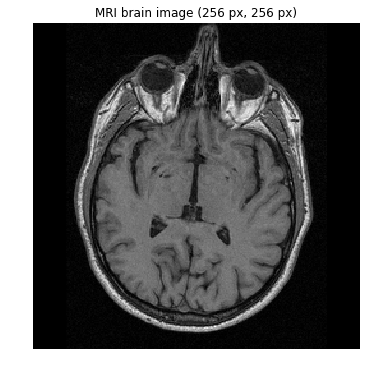

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

---

### 1.2 Pre-processing
In the first step, we will perform a pre-processing on the image and this result will be used for all the different methods. In order to do so, we will first perform a median filter to remove the noise without a high blurring and after that, we will equalize the histogram of our image. We used OpenCV package for this part. In each of the next parts, we may use one of these results or the original image based on the segementation method:

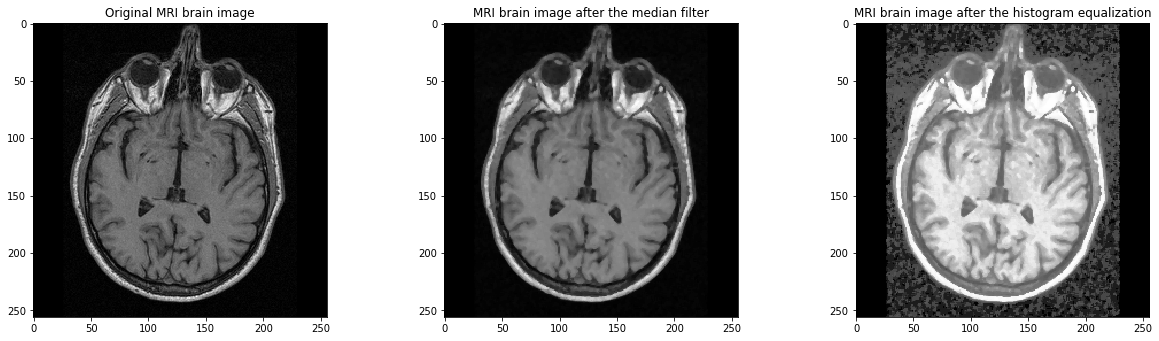

In [4]:
# Pre-processing

import cv2 # Imports the OpenCV library
import numpy as np 
%matplotlib inline

# Performs the median filter based on 3 points
brain_im_medfil = cv2.medianBlur(brain_im,3) 

# Performs histogram equalization
brain_im_eqhist= cv2.equalizeHist(brain_im_medfil) 

# Plotting the original, median filtered, and equalized histogram images
titles = ['Original MRI brain image', 'MRI brain image after the median filter', 'MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_medfil, brain_im_eqhist]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

### 1.3 Region growing
In this part, we applied the **region growing** method to perform the segmentation of the brain. The first step is to perform a seeding and it should be in the right region which is the brain for us. After that, we begin to grow the region with the aid of the neighbor points. Parallel to this, we check the contrast of the neighboring points to find the criteria of the brain part which is where we have to stop. 

We tried the region growing method twice with the 4 main connectivity points, and the all 8 eight connectivity points and finally we chose the 4-connectiviy method as it was faster and also the result was slightly better for this specific image. 

The total area of brain is 16355 pixels from the region growing method.


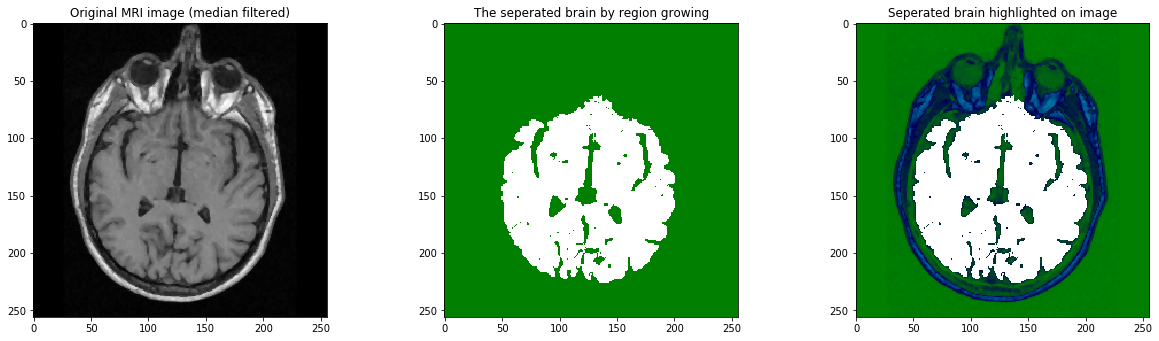

In [5]:
# Region Growing 

img_ready=brain_im_medfil.copy() # Making a copy of image
threshold=6 # Setting the threshold of the contrast
seed=(157,157) # Seeding the first point
list_points=[]
finished_list=[]
list_points.append(seed)
region_growing_result=np.ones(img_ready.shape) # Making the raw matrix of seperated brain

while (len(list_points)>0):
    
    # The current point that will be checked is called the new seed
    new_seed=list_points[0]
    new_seed_x,new_seed_y=new_seed
    
    # Checking the threshold for the upper point 
    check_point= (new_seed_x,new_seed_y+1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    # Checking the threshold for the point on right
    check_point=(new_seed_x+1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    # Checking the threshold for the point on left
    check_point=(new_seed_x-1,new_seed_y)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
        
    # Checking the threshold for the below point
    check_point=(new_seed_x,new_seed_y-1)
    if (np.abs(int(img_ready[new_seed]) - int(img_ready[check_point])) < threshold and check_point not in finished_list and check_point not in list_points): 
        list_points.append(check_point)
        region_growing_result[check_point]=0
    
    # Adding the current point to the final list of seperated points
    finished_list.append(new_seed)
    region_growing_result[new_seed]= 255
    
    # Remove the current point from check list
    list_points.pop(0)

# Printing the size of the brain
total_area = len(finished_list)
print('The total area of brain is {} pixels from the region growing method.'.format(total_area))

region_growing_result= region_growing_result.astype(np.uint8)
Highlighted_brain = brain_im_medfil | region_growing_result

# Plotting the original image (with median filter), the seperated area, and highlighting the seperated brain on the original image
titles = ['Original MRI image (median filtered)', 'The seperated brain by region growing', 'Seperated brain highlighted on image']
outputs = [brain_im_medfil, region_growing_result, Highlighted_brain]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    if i == 1:
        ax.imshow(outputs[i-1], cmap='gray')
    else:
        ax.imshow(outputs[i-1], cmap='ocean')
    plt.title(titles[i-1])
plt.show()

### _Comment:_ 

While implementing the region growing method, we chose the initial seed point as will be inside of the brain. One can also try with choosing a different seed which should be again inside of the brain. The threshold value (6 here) which is used to separete should be based on the contrast on the image. With the chosen parameters we obtained the best result for the region growing method. As it can be seen above, we counted 16355 pixels for the brain region, and it seems from the above result on the right image, we captured the most part of the brain.

---

### 1.4 Contour detection
An edge in an image is defined as the points where a sharp transition of intensity is observed. In other words, edges can be defined at where we see a sharp change in the image brightness or sudden changes of discontinuities in an image. It is known as contour, when those points are connected to form a closed-homogeneous boundary or to follow a continious form. Moreover, the process to define a region is to search for sharp edges is called contour-based methods.

Many edge detection algorithms have been developed to identify the boundaries of homogeneous regions in an image based on properties such as intensity and texture. They are mostly based on computation of the intensity gradient vector (i.e. Robert operator, Prewitt,Sobel), which, in general, is sensitive to noise in the image. In order to suppress the noise, some spatial averaging may be combined with differentiation such as the Laplacian of Gaussian operator and the detection of zero crossing.

In order to compute the size of the brain, we first separated the foreground objects from the background. We used Sobel operator so as to get brain by detecting edges of the skull and remove it from the original image. After observing Sobel's effect on the image, because of the presence of the noise on the image, we couldn't get homogeneous edge detection for the skull. Hence, before applying **Sobel operator**, we applied **Gaussian filter** on the original image. With this blurred image, the contour of skull is captured better. Afterwards, we tried to find the threshold on the edge values in order to separate better the skull parts (let's call them strong edges for the sake of clarity with our code below) from the brain parts since the pixel values, the tissues, inside the brain is usually similar. The idea here is to use the strong edges as a background by filling the interior of it and then subtracting the skull parts from the first contour detection using this background. 

After this operation, we observed that we didn't have good size of brain compare to original one, hence we decided to apply some morphological operations such as dilation (so as to strengthen brain part of the image). In the end, we detected the contour of the image and counted the pixels of the brain areas by using the function that we wrote `find_biggest_contour()` which selects the largest contour part such that brain is the largest part of the contour.

Mean of Sobel is 0.022521248175536676


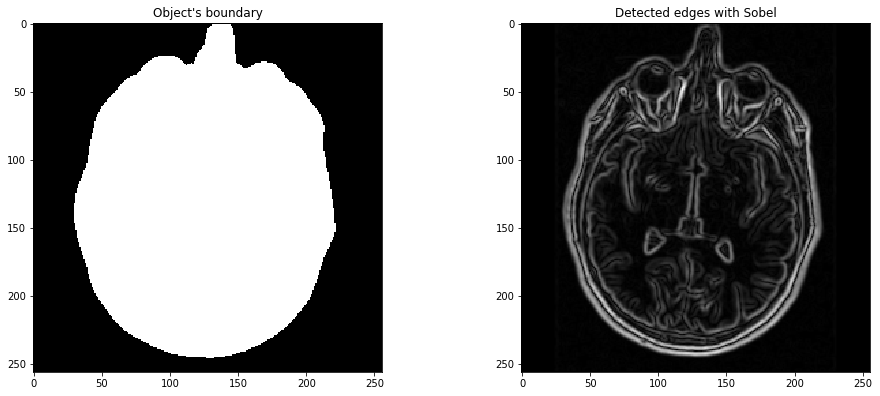

In [6]:
#Contour Detection

from skimage.filters import sobel
from scipy.ndimage.morphology import binary_fill_holes

# Smoothing out any of the small image noise 
GaussianBlur_im = cv2.GaussianBlur(brain_im, (5,5), 0)

# Applying Sobel operator to detect edges
sobel_im=sobel(GaussianBlur_im)
print("Mean of Sobel is {}".format(sobel_im.mean())) # To define the threshold below we needed to see the mean so we choose a value that is close to the mean so as to gather tissues better. 

# Thresholding on sobel image
_,thresh = cv2.threshold(sobel_im,0.021,255,0)
separated_object = binary_fill_holes(thresh).astype(np.uint8)
#print(np.max(separated_object))

# Plotting object's boundary and detected edges with Sobel detecting operator
titles = ['Object\'s boundary', 'Detected edges with Sobel']
outputs = [separated_object, sobel_im]

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

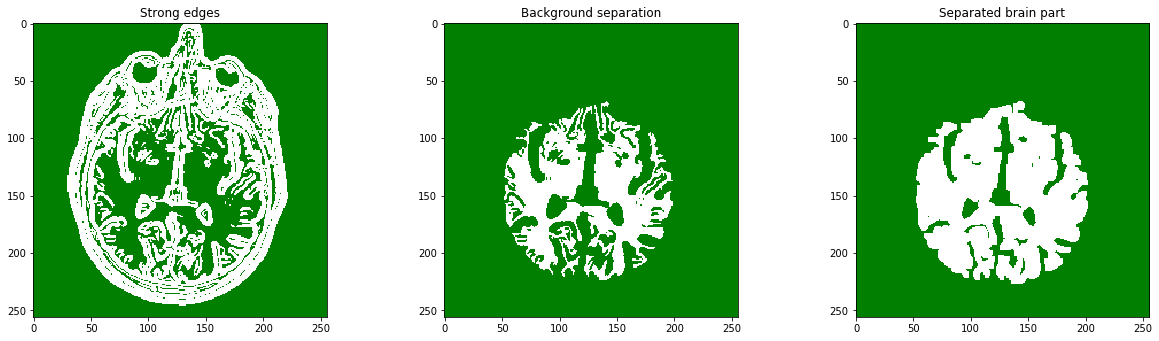

In [7]:
from skimage import morphology

# Applying the threshold on the edges in order to detect strong edges that of skull part
_,thresh = cv2.threshold(sobel_im,0.021,255,cv2.THRESH_BINARY) 
        # 0.021 is chosen as a threshold, from above code it can be seen that the mean of the pixel values of the image after 
        # applying Sobel operator, we chose a threshold value which is very close to that mean so as to gather tissues better. 

# Morphological operation: Seperating the background and removing the small objects from the skulls
cleaned_brain = morphology.remove_small_objects((separated_object*255-thresh).astype(bool), min_size=1000)

# Morphological operation: Applying dilation on the brain part
kernel2 = np.ones((2,2),np.uint8)
brain_part = cv2.morphologyEx(cleaned_brain.astype(np.uint8), cv2.MORPH_DILATE,kernel2, iterations =3)

# Plotting results
titles = ['Strong edges', 'Background separation', 'Separated brain part']
outputs = [thresh, cleaned_brain, brain_part]
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='ocean')
    plt.title(titles[i-1])
plt.show()

The area of the largest contour is 15725 pixels from the contour detection method.


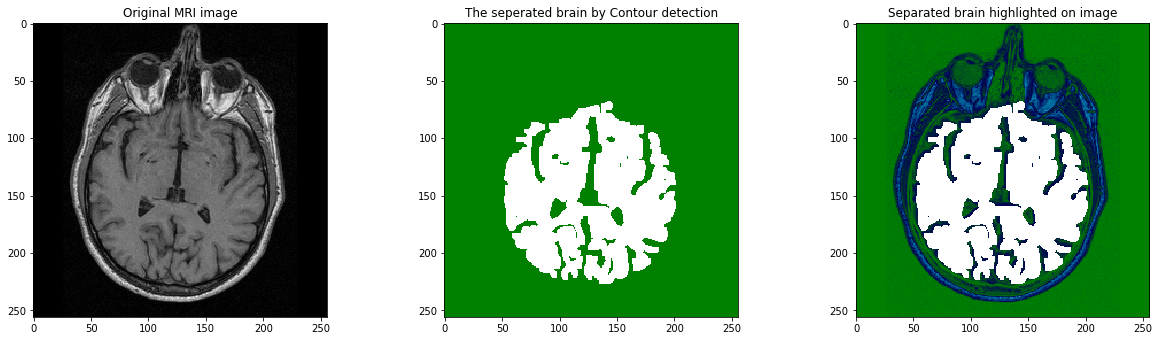

In [8]:
def find_biggest_contour(image):
    # Finding contours from the brain part image that we obtained in the previous step
    img_ctr, contours, hierarchy = cv2.findContours(image.astype(np.uint8).copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    idx_of_largest = np.argmax(contour_sizes[0][0])
    cnt = contours[idx_of_largest]
    final_contour=cv2.drawContours(img_ctr, cnt, 0, (0,255,0), 0)
    total_area=contour_sizes[idx_of_largest]
    print('The area of the largest contour is {} pixels from the contour detection method.'.format(int(total_area[0])))
    return final_contour, img_ctr

final_contour, img_ctr = find_biggest_contour(brain_part)
compare_images =  (final_contour*255) | brain_im 

# Plotting results
titles = ['Original MRI image', 'The seperated brain by Contour detection', 'Separated brain highlighted on image']
outputs = [brain_im, img_ctr, compare_images]
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    if i == 1:
        ax.imshow(outputs[i-1], cmap='gray')
    else:
        ax.imshow(outputs[i-1], cmap='ocean')
    plt.title(titles[i-1])
plt.show()

### _Comment:_ 

We chose 0.021 value as a threshold, from above code the mean of the pixel values of the image after applying Sobel operator can be seen. We chose a threshold value which is very close to that mean so as to gather tissues better. With above code and parameters, we got the best result as possible. The area of the largest contour is 15725 pixels from the contour detection method. With this method we counted the number of pixels frm the brain part is slightly less than the one we found with the region growing method. However, by changing the parameters we saw that capturing the contour for each wrinkle of the brain on the bottom part was really difficult.  

---

### 1.5 Additional method I: Thresholding 
In this part, we performed the **thresholding method** to find the size of brain in pixels. In order to find the right threshold first, we showed the histogram of the original (median filtered) image and the histogram equalized version of it:

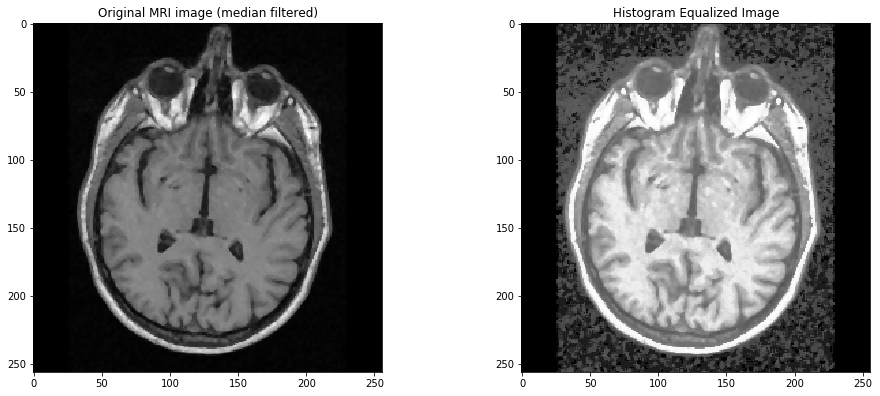

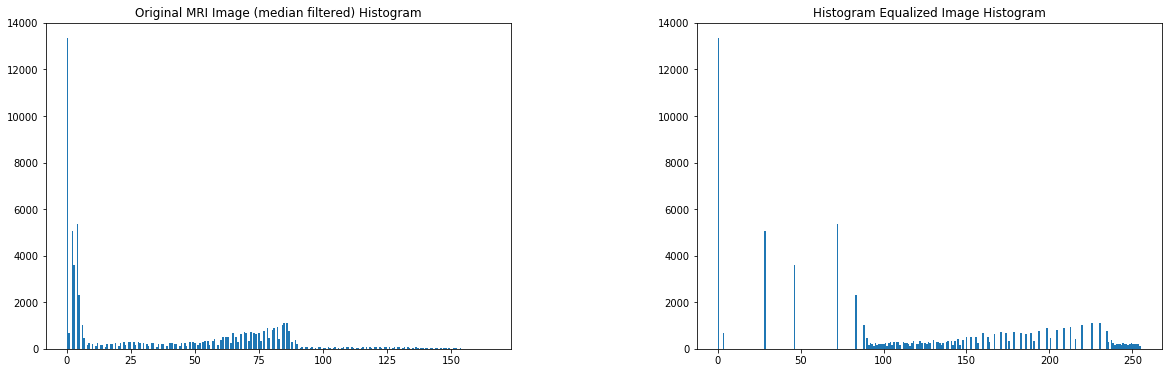

In [9]:
#Thresholding

#Plots the original (median filtered) image and the histogram equalized image
titles = ['Original MRI image (median filtered)', 'Histogram Equalized Image']
outputs = [brain_im_medfil, brain_im_eqhist]
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

#Plots the histogram of these two images below them
titles = ['Original MRI Image (median filtered) Histogram', 'Histogram Equalized Image Histogram']
outputs = [brain_im_medfil, brain_im_eqhist]
fig = plt.figure(figsize=(20,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.hist(outputs[i-1].ravel(), bins=256)
    plt.title(titles[i-1])
plt.show()


Above figures show the histogram of original image and the histogram equalized image. As it is clear on the above image, the equalized histogram image is easier to study and we can see that near the 150, the histogram bars will begin to separate and there should be the beginning of the important parts which are not the noise. If we threshold the image from there, we will have the whole skull and brain together. If we go further in the histogram, we can see that there is a drop around 240 (it is around 80 in the original image), and if we seperate it from there, we will have the skull which is the brightest part of the image. So we will perform 2 thresholdings to get the whole skull and brain and to get the skull alone and then we remove the skull from the latter to get the brain alone.

In the next part, the main code for thresholding can be found. After performing the thresholding, we did a few morphological improvements on the image. For this part, we used the OpenCV library and for the morphology part, we used the Scikit Image library.

The total area of brain is 16194 pixels from the thresholding method.


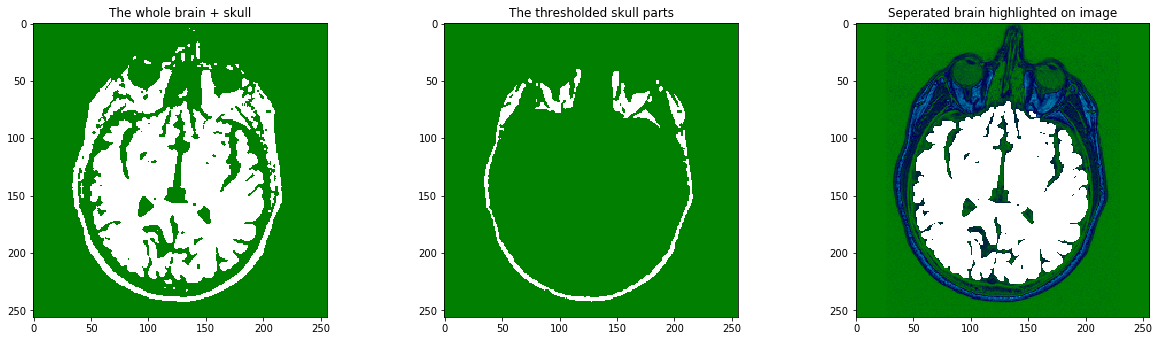

In [10]:
# Importing the scikit image library
from skimage.morphology import square

# Finding all the white areas using a binary thresholding on equalized histogram image
_,all_the_white_areas= cv2.threshold(brain_im_eqhist,155,255,cv2.THRESH_BINARY)

# Finding the white areas which are not a part of brain
# Using a binary thresholding on equalized histogram image
_,white_areas_which_are_not_the_brain= cv2.threshold(brain_im_eqhist,240,255,cv2.THRESH_BINARY)

# Finding the brain itself
brain_im_thresholded =all_the_white_areas-white_areas_which_are_not_the_brain

# Performing mathematical morphology
brain_im_thresholded= skimage.morphology.binary_closing(brain_im_thresholded, selem = square(2), out=None)
brain_im_thresholded= skimage.morphology.remove_small_objects(brain_im_thresholded.astype(bool), min_size=900)
brain_im_thresholded= skimage.morphology.binary_erosion(brain_im_thresholded, selem=np.ones([2,2]))
brain_im_thresholded= skimage.morphology.binary_dilation(brain_im_thresholded, selem=np.ones([3,3]))

# Printing the size of the brain in pixels
thresholding_result= brain_im_thresholded.astype(np.uint8)
total_area = np.sum(thresholding_result)
print('The total area of brain is {} pixels from the thresholding method.'.format(total_area))

thresholding_result=thresholding_result*255
Highlighted_brain = brain_im | thresholding_result

# Plotting results
titles = ['The whole brain + skull', 'The thresholded skull parts', 'Seperated brain highlighted on image']
outputs = [all_the_white_areas, white_areas_which_are_not_the_brain, Highlighted_brain]
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='ocean')
    plt.title(titles[i-1])
plt.show()

### _Comment:_ 
With the thresholding method, we didn't capture the brain parts where especially on the bottom of the image as it can be seen above. We used 155 and 240 on the equalized histogram image as the threshold values which we have found by analysis of the histogram. Based on the 16194 pixels area of the brain, the final shape, and comparing to the first two method that we applied, the threshold method performed a bit better job than the contour detection but it was not perfect in comparison to region growing.

In fact, the MRI images are good materials for the thresholding method, as they are grayscale and they have mostly strong transitions. So this method can work well here, although it is not a really powerful method in general.

### 1.6 Additional method II: Edge Detection
As another edge detection method, we used Canny edge detection with Hough Circles. The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny edge detection algorithm is basically follows these steps:

- Noise reduction
- Gradient calculation
- Non-maximum suppression
- Double threshold
- Edge Tracking by Hysteresis

General idea here is the same with the contour detection method. In order to compute the size of the brain, we first separated the foreground objects from the background. Because of the presence of the noise on the image, we couldn't get homogeneous edge detection for the skull. Hence, we applied **Median filtered** on the original image with a kernel size of 5. With this blurred image, the contour of skull is captured better. With Hough Gradient method, we encircled the brain part from the skull. The parameters' explanation can be found in the below code while we performed the Hough Gradient. Since, we have prior knowledge about where the brain part is, we tuned the circle's center and radius values by observing that at which point we capture the brain better. We have created this circle masks, one for encircling the brain and the other one for ensuring the larger radius when doing edge detection of the image on this masking area. We also used mathematical morphology such as dilation. So, the methods that we follow:

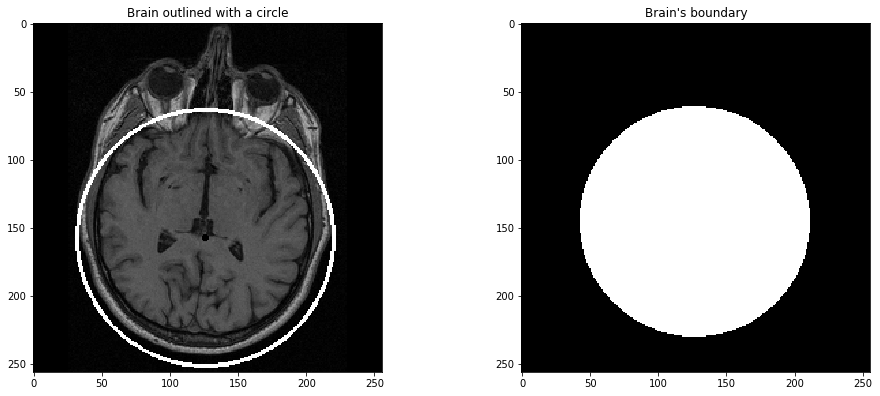

In [11]:
#Edge detection 

output = brain_im.copy()

# Detect circles in the image via Hough Circles
imm = cv2.medianBlur(brain_im.copy(), 5)
rows = imm.shape[0]
circles = cv2.HoughCircles(imm, cv2.HOUGH_GRADIENT, 1.2, rows/4,  param1=100, param2=50, minRadius=50, maxRadius=125)
"""
circles: A vector that stores sets of 3 values: x,y,r for each detected circle.
HOUGH_GRADIENT: Define the detection method. 
dp = 1.2: The inverse ratio of resolution.
min_dist = rows/4: Minimum distance between detected centers.
param_1 = 100: Upper threshold for the internal Canny edge detector.
param_2 = 50: Threshold for center detection.
min_radius = 50: Minimum radius to be detected. If unknown, put zero as default.
max_radius = 125: Maximum radius to be detected. If unknown, put zero as default.
"""

# Ensure at least some circles were found
if circles is not None:
    circles = np.uint16(np.around(circles))
    # Loop over the (x, y) coordinates and radius of the circles
    for i in circles[0, :]:
        # In order to capture the brain better, we tuned the center
        center = (i[0]+2, i[1]+2)
        #print(center)
        # Center of circle
        cv2.circle(output, center, 1, (0, 100, 100), 2)
        # Outline of circle
        radius = i[2]
        #print(radius)
        # In order to capture the brain better, we tuned the radius  
        cv2.circle(output, center, radius+7, (255, 255, 255), 2)

# Preparing template
center_t = (127,145)
radius_t = 83
blank = np.zeros_like(brain_im)
circle_t = cv2.circle(blank.copy(),center_t,radius_t,(255,255,255),2)
brains_boundary = binary_fill_holes(circle_t).astype(np.uint8)

# Plotting results
titles = ['Brain outlined with a circle', 'Brain\'s boundary']
outputs = [output, brains_boundary]

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

The number of pixels counted as the brain are 14902


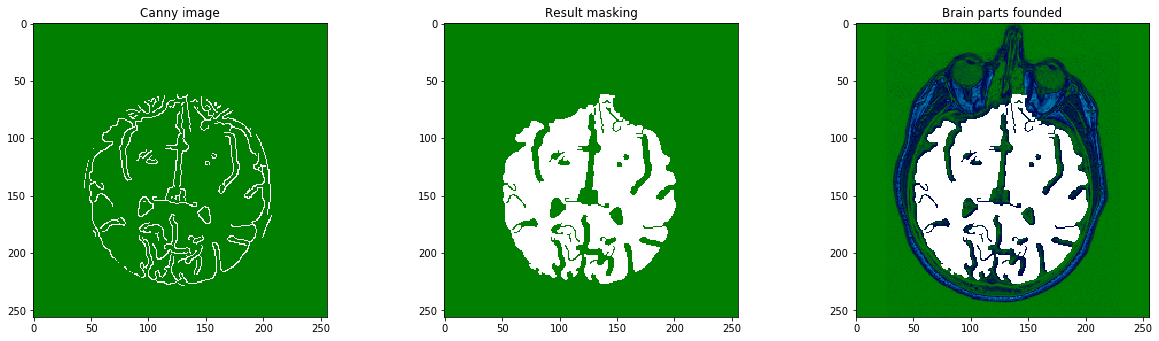

In [12]:
from skimage.feature import canny

# Detect the edges  within the mask(target area = brain)
canny_image = canny(brain_im.copy(), sigma=1.3, mask = brains_boundary.astype(bool)).astype(np.uint8) 

# Morphological operation: Applying dilation on the brain part
kernel2 = np.ones((2,2),np.uint8)
brain_part_edges = cv2.morphologyEx(canny_image.astype(np.uint8), cv2.MORPH_DILATE, kernel2, iterations = 1)
separated_object_c = 1 - binary_fill_holes(brain_part_edges).astype(np.uint8)
masked_image = separated_object_c & brains_boundary
cleaned_brain_c = morphology.remove_small_objects(masked_image.astype(bool), min_size=1000)
result_masking = cv2.morphologyEx(cleaned_brain_c.astype(np.uint8), cv2.MORPH_DILATE, kernel2, iterations = 1)

#Count the area of the brain
print('The number of pixels counted as the brain are', np.sum(result_masking))
compare_images = brain_im | (result_masking*255)

# Plotting results
titles = ['Canny image', 'Result masking', 'Brain parts founded']
outputs = [canny_image, result_masking, compare_images]

fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='ocean')
    plt.title(titles[i-1])
plt.show()

### _Comment:_

From the above images, it can be seen that we didn't capture well the brain part, however this result is the best result that we could obtain with this method. Here, we applied Canny edge detection by setting the sigma value that detects enough edges inside the brain. We then dilated those edges in order to have better connected parts for the edges that are close to each other. Using the mask that we created above, we removed the outer parts of the brain like we did in contour detection method. Moreover, even if we tried to use the same center for both circles, the result wasn't as expecting. Hence, that's why we decided to go with the above parameters. Finally, we were able to count the number of pixels from the brain part as 14902 which is not as good as the other methods' result.

### 1.7 Conclusion
The results that we have found for all 4 methods are not quite similar to each other. For the _region growing_, _thresholding_ and _contour detection_ method we can see from the above results that brain parts are well segmented and it seems that the _region growing_ is the best one here. Also, we were expecting to see a similar result for the _contour detection_ and _canny edge detection_ methods, but _canny edge detection_ performed lesser than _contour detection_. It is also interesting that we only applied once the dilation operation, and when we increased it, the result was worse than before. In fact, the masking method was an efficient method to segment the area since we had prior knowledge of where the brain part is located. Compare to this, if we were given a different image where the brain part is located in different place, (like rotated version of brain image) we couldn't be able to capture the brain parts by using masking like we did above. Also, it is undeniable the usefulness of the morphological operations while segmenting an image. 

Last but not least, which method works better is actually depends on the image and it is needed to decide very carefully. For example, the good result from the _thresholding_ method here was mostly because of the nature of the MRI image and it may not work well in other problems, like for the colored images.

---

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [13]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


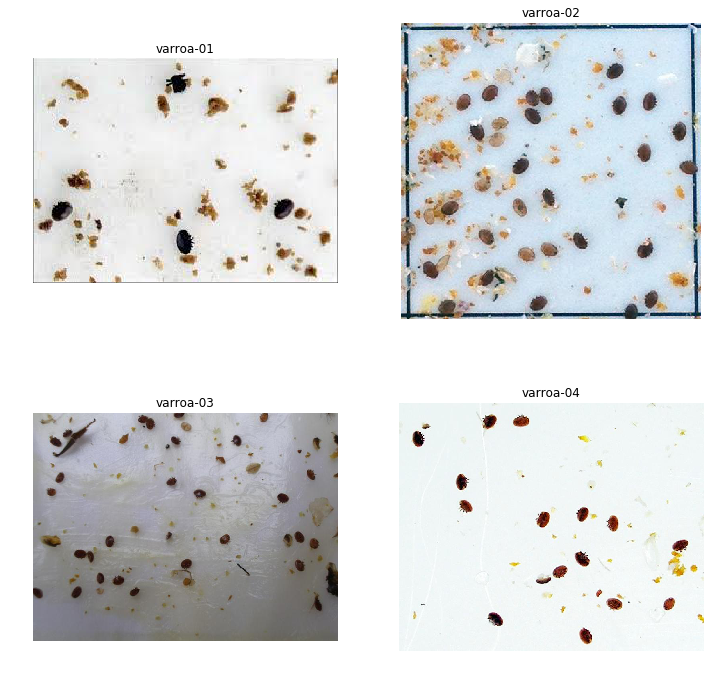

In [14]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [15]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [16]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

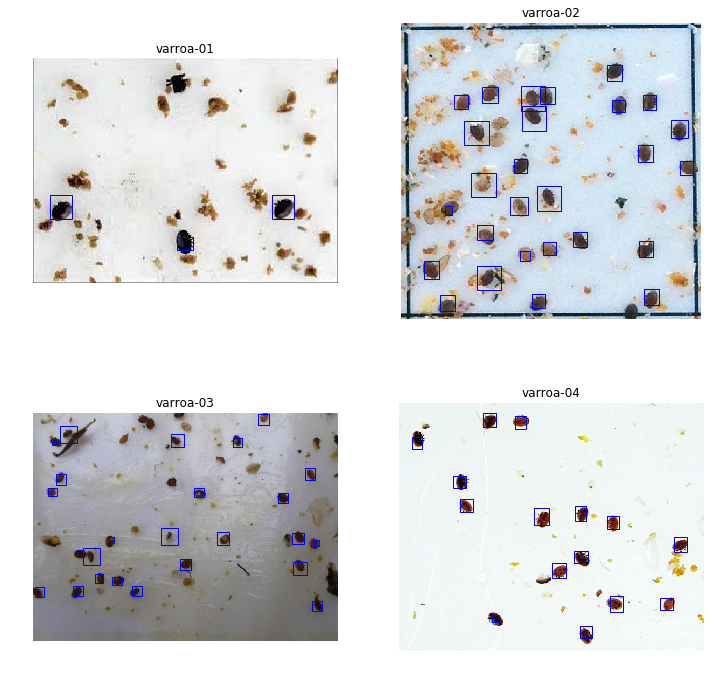

In [17]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

---

### 2.2 Count the number of Varroa on each picture

Hint: `skimage.measure.label` might be useful to label the thresholded image

First, we would like to perform a thresholding on the images to seperate the varroas. As we have to apply a unique method on the all images and due to the difference in the lightness of them, we perform a conditional lightness improvement. After that, we transform the images to grayscale for thresholding. When the thresholding is finished, we perform some morphological operations to improve the result of the thresholding. At the end of this section, the resulted images of this segmentation approach have been shown:

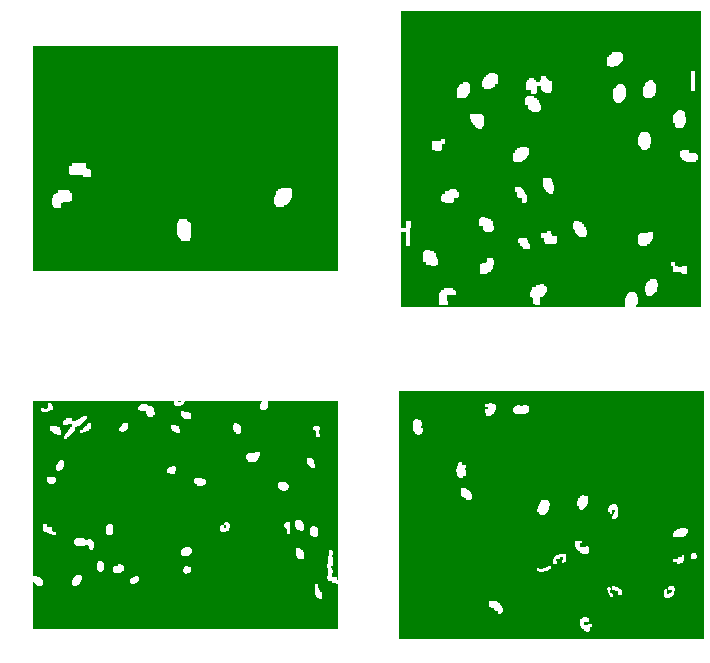

In [18]:
from scipy.ndimage import morphology

def varroa_thresholding(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=210)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=170)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    return image_processed

# Applying the thresholding function on the image collection
ic_thresholded=skimage.io.ImageCollection(ic,load_func=varroa_thresholding)

# Plotting the thresholded image collection
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im in zip(axes.ravel(), ic_thresholded):
    ax.imshow(im,cmap='ocean')
    ax.axis('off')
plt.show()


Now it's time to perform a labeling on the divided varroas. In order to do so, we use the `skimage.measure.label` function from the Scikit Image library. After that, we patch the images with our labels and the ground truth to perform a comparison. We also count the number of varroas for each image to compare with the ground truth.

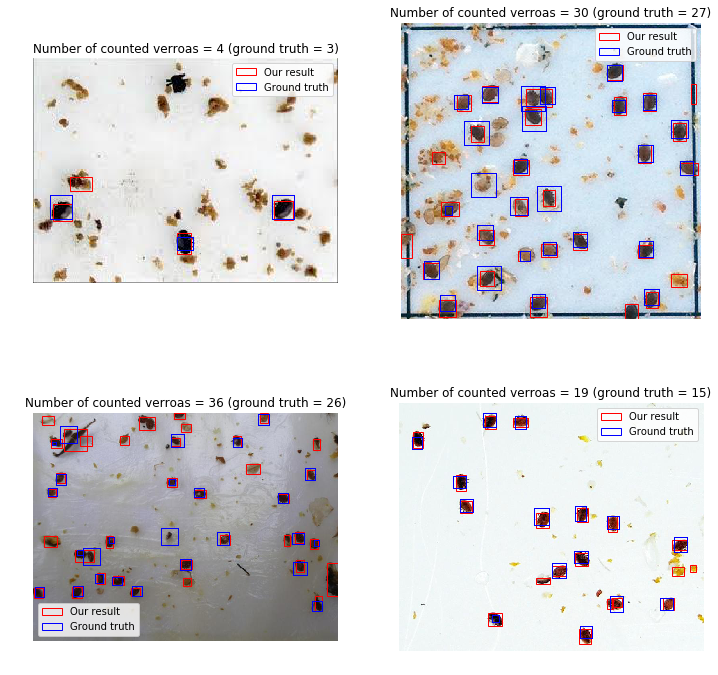

In [19]:
import matplotlib.patches as mpatches

# Function performs the labeling of varroas on the thresholded image
def varroa_labeling(image_processed):
    labels=skimage.measure.label(image_processed,neighbors=8,background=0,return_num=False)
    return labels    

# Applies the labeling function on the thresholded image
ic_labeled=skimage.io.ImageCollection(ic_thresholded,load_func=varroa_labeling)

# Patching the image with our results and the ground truth
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
    ax.imshow(im,cmap='ocean')
    s=0
    for region in skimage.measure.regionprops(ig):
        
        # A condition to make sure that the region area is big enough
        if region.area >= 100:
            
            # Drawing the rectangle for our results
            y_min, x_min, y_max, x_max = region.bbox
            rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect_detection)
            
            # Counting the number of varroas
            s=s+1
            
            # Drawing the ground truth
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='blue',facecolor='none')
                ax.add_patch(rect_ground_truth)
    

    # Plotting the image with the number of counted varroas as the title
    ax.axis('off')
    ax.set_title('Number of counted verroas = %s (ground truth = %s)'% (s,np.size(annotations)))
    leg=['Our result','Ground truth']
    ax.legend(leg)
plt.show()


As it is clear on the images, at first glance, we almost have a good overlap between the number of varroas from our thresholding method and the ground truth. However, in order to perform a precise analysis, we have to use some more advanced tools like the intersection over union:

---

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In this part, we have to find the intersection over union with respect to the ground truth for each of the detected varroas. In order to do so, we have to find the nearest ground truth to each of the detected ones. Here, we used an algorithm that checks the distance of the center point of the labeled varroa, with all the center points of the varroas from the ground truth and find the least distance. Then, it will use the`intersection_over_union` function to find this quantity. After that, we patch the image with the percentage of IoU for each of the labeled varroas.

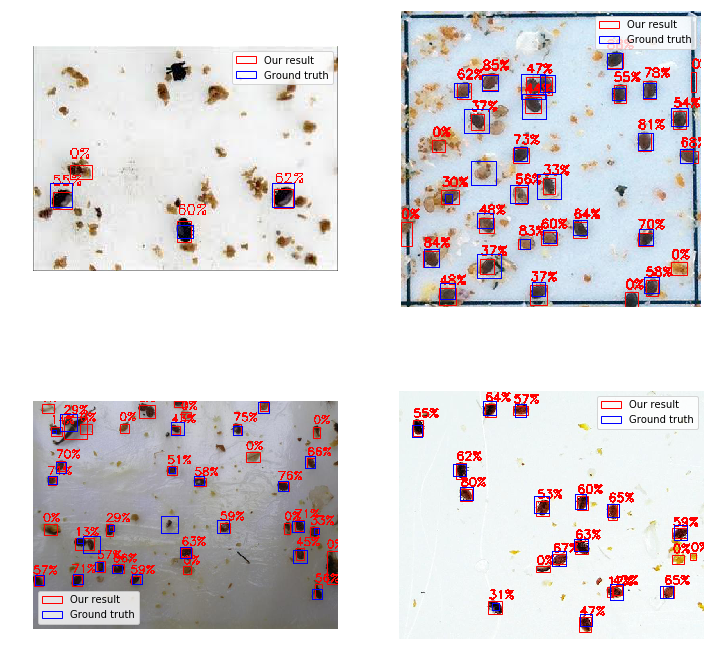

In [30]:
from math import sqrt

# Finds the distance between two points
def distance_finder(x_1,y_1,x_2,y_2):  
    dist = sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)  
    return dist 

# Finds the intersection over union of two rectangles
def intersection_over_union(rect_1, rect_2):
    x_1 = max(rect_1[0], rect_2[0])
    y_1 = max(rect_1[1], rect_2[1])
    x_2 = min(rect_1[2], rect_2[2])
    y_2 = min(rect_1[3], rect_2[3])

    rect_1_area = (rect_1[2] - rect_1[0] +1) * (rect_1[3] - rect_1[1] +1)
    rect_2_area = (rect_2[2] - rect_2[0] +1) * (rect_2[3] - rect_2[1] +1)
    intersection = max(0, x_2 - x_1 +1) * max(0, y_2 - y_1 +1)
    IoU = intersection / float(rect_1_area + rect_2_area - intersection)
    
    return IoU


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
    dist=[]
    for region_labeled in skimage.measure.regionprops(ig):
        
        # Check if the area of labeled region big enough
        if region_labeled.area >= 100: 
            dist=[]
            IoU=[]
            
            # Checking each labeled region with all the ground truth regions 
            # and find the one with the minimum distance
            for anno in annotations:
                dist.append(distance_finder(region_labeled.centroid[1],region_labeled.centroid[0],(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
            least_distance=np.argmin(dist)
            
            # Finding the intersection over union between the labeled area and the ground
            # truth with the least distance
            bbox_region_truth=annotations[least_distance]
            IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled.bbox[1],region_labeled.bbox[0],region_labeled.bbox[3],region_labeled.bbox[2]))
            del dist
            
            # Implementing the decent text size and thickness based on the size of image
            if im.size<200000:
                text_size=0.4
                text_thickness=1
            elif im.size<600000:
                text_size=0.6
                text_thickness=2
            elif im.size<1000000:
                text_size=0.8
                text_thickness=2
            else: 
                text_size=1
                text_thickness=3 
                
            # atching the image with IoU of each detection
            cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(255, 0, 0),thickness=text_thickness)
        ax.imshow(im,cmap='ocean')
    
    for region in skimage.measure.regionprops(ig):
        
        # Check if the area of labeled region big enough
        if region.area >= 100:
            
            # Drawing the rectangles for our results
            y_min, x_min, y_max, x_max = region.bbox
            rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect_detection)
            
        # Drawing the rectangles for the ground truth    
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='blue',facecolor='none')
                ax.add_patch(rect_ground_truth)
   
    # Plotting the collection of images
    ax.axis('off')
    leg=['Our result','Ground truth']
    ax.legend(leg)
plt.show()
        

---

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Here, we will use different indicators to evaluate the precision of our detections. In order to do so, we will use the `Precision_Recall_F1_score` that receives the desired threshold as an input and calculates the three important indicatorsL: precision, recall, and F1-score. According to the IoU threshold, the function will patch the image with the rectangles of green or red.

----  T=0.5 -----


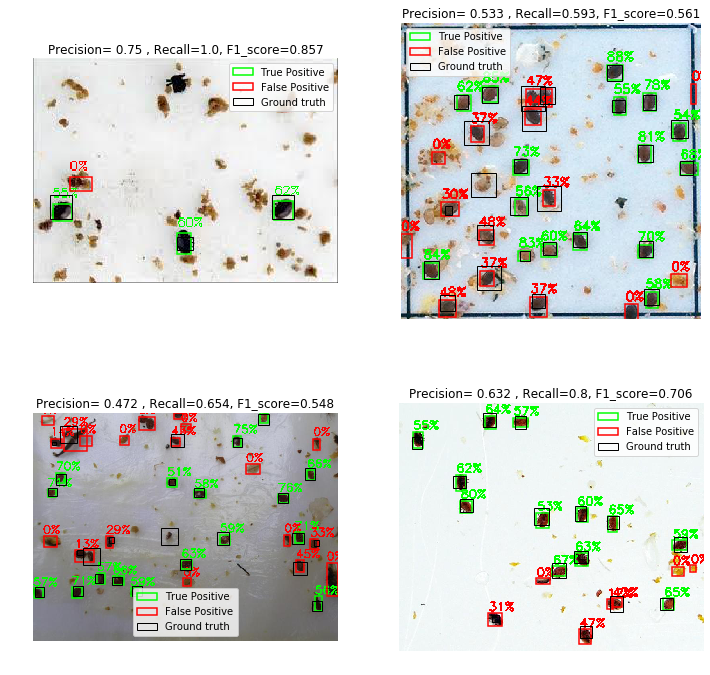

----  T=0.9 -----


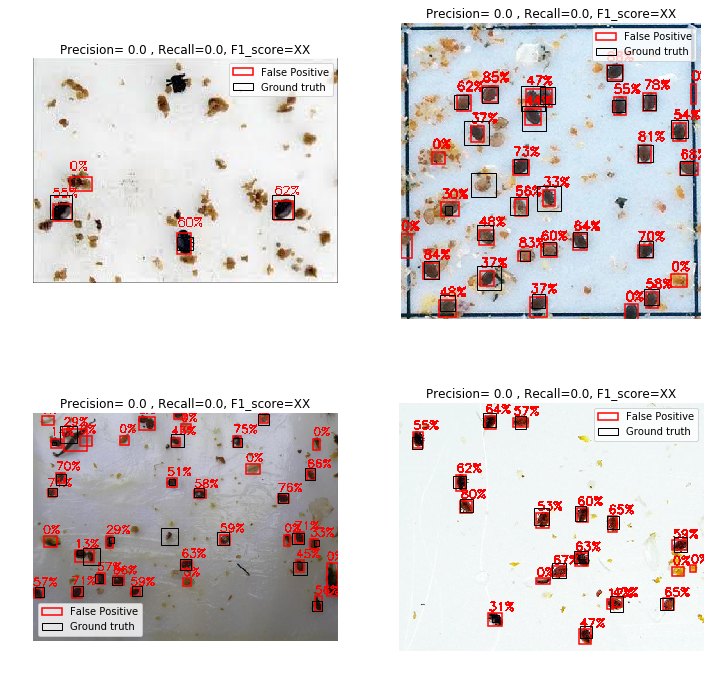

In [31]:
# Finds precision, recall, and F1-score of each of the detected varroas based on the threshold
def Precision_Recall_F1_score(T):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for ax, im, ig , annotations  in zip(axes.ravel(), ic,ic_labeled, annotations_xmls):
        
        # Initializing the variables
        dist=[]
        true_positive=0
        false_positive=0
        
        for region_labeled in skimage.measure.regionprops(ig):
            # Check if the area of labeled region big enough
            if region_labeled.area >= 100: 
                dist=[]
                IoU=[]
                
                # Checking each labeled region with all the ground truth regions 
                # and find the one with the minimum distance
                for anno in annotations:
                    dist.append(distance_finder(region_labeled.centroid[1],region_labeled.centroid[0],(anno['bbox'][0]+(anno['bbox'][2])/2),(anno['bbox'][1]+(anno['bbox'][3])/2)))
                least_distance=np.argmin(dist)
                
                # Finding the intersection over union between the labeled area and the ground
                # truth with the least distance
                bbox_region_truth=annotations[least_distance]
                IoU=intersection_over_union((bbox_region_truth['bbox'][0],bbox_region_truth['bbox'][1],bbox_region_truth['bbox'][0]+bbox_region_truth['bbox'][2],bbox_region_truth['bbox'][1]+bbox_region_truth['bbox'][3]),(region_labeled.bbox[1],region_labeled.bbox[0],region_labeled.bbox[3],region_labeled.bbox[2]))
                del dist
                
                # Implementing the decent text size and thickness based on the size of image
                if im.size<200000:
                    text_size=0.35
                    text_thickness=1
                elif im.size<600000:
                    text_size=0.6
                    text_thickness=2
                elif im.size<1000000:
                    text_size=0.8
                    text_thickness=2
                else: 
                    text_size=1
                    text_thickness=3
                    
                # Patching the true positives with green rectangles and numbers
                if (IoU>=T):
                    cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(0, 255, 0),thickness=text_thickness)
                    y_min, x_min, y_max, x_max = region_labeled.bbox
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='lime', linewidth=1.5)
                    line_1=ax.add_patch(rect_detection)
                    # Counting the number of false positives
                    true_positive=true_positive+1
            
                # Patching the false positives with red rectangles and numbers
                else:
                    cv2.putText(im,'{}%'.format(((int(IoU*100)))),(int(region_labeled.bbox[1] ),int(region_labeled.bbox[0]) -5),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=text_size, color=(255, 0, 0),thickness=text_thickness)
                    y_min, x_min, y_max, x_max = region_labeled.bbox
                    rect_detection = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,fill=False, edgecolor='red', linewidth=1.5)
                    line_2=ax.add_patch(rect_detection)
                    # Counting the number of false positives
                    false_positive=false_positive+1
        ax.imshow(im,cmap='ocean')
        
        # Finding the number of false negatives for each image
        false_negative=np.size(annotations)-true_positive
        
        # Finding the precision and recall for each of the figures
        precision=true_positive/(false_positive+true_positive)
        recall=true_positive/(false_negative+true_positive)
        
        # Finding the precision and recall for each of the figures
        # If we have a zero in the denominator of the F1_score function, the output will be XX
        if (precision+recall)==0:
            f1_score='XX'
        else:
            f1_score=(2*precision*recall)/(precision+recall)
        
        # Drawing the rectangles for the ground truth    
        for anno in annotations:
                rect_ground_truth = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='black',facecolor='none')
                line_3=ax.add_patch(rect_ground_truth) 


        # Adding the titles that contain the precision, recall and F1-score
        if (f1_score)=='XX':
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), f1_score))
        else:
            ax.set_title("Precision= %s , Recall=%s, F1_score=%s" % (np.round(precision,3), np.round(recall,3), np.round(f1_score,3)))
        
        # Adding the legends
        if 'line_2' in locals() and 'line_1' in locals():
            ax.legend((line_1, line_2, line_3), ('True Positive','False Positive','Ground truth'))
        elif 'line_1' in locals():
            ax.legend((line_1, line_3), ('True Positive','Ground truth')) 
        else:
            ax.legend((line_2, line_3), ('False Positive','Ground truth')) 
        ax.axis('off')          
    plt.show()
    return IoU

# Calling the function for the two different thresholds
T=0.5
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T)
T=0.9
print("----  T=%s -----" % (T) )
P=Precision_Recall_F1_score(T)
        

As you can see in the above images, when we put the threshold which is not high, (up to 0.5) the method can perform better job and we will have a F1-score more than 0.5 for all the images. However, when we increase the threshold more than this, the pure segmentation methods, fail to provide a good result. In fact, it is the reason that we have to perform the description and classification. In other words, without the use of advanced machine learning classifiers, it is hard to achieve a high precision. In fact, when you use the classifiers, you can divide the thresholded parts based on the more precise features and it helps to avoid the wrong results.

In addition to this, as it is clear on the top-left image, the ground truth is not perfect and divided regions are sometimes bigger and smaller than the actual varroas. If we don't have a precise ground truth, it is better to set the threshold of the intersection over union lower or to use some other methods just based on the number of intersection pixels and the normalized number (Intersection over Union).

Finally, as it is clear on the images, this segmentation method works better for the recall in comparison to the precision and it means that there is less false negatives in comparison to the false positives. In fact, this method can find varroas better, but it may also segment some parts which are not actually varroas as a mistake

### 2.5 Conclusion

In this part, we used the segmentation methods, mostly based on thresholding, to indentify the presence of varroas in a beehive based on a set of real pictures and we compared our result to the ground truth data which is provided by the beekeepers.

In this way, we used the different indicators like Recall and F1-score to evaluate the precision of our methods. The precision, recall, and F1-score for a 0.5 threshold of IoU were acceptable but with a higher threshold, the method failed to provide a good overlap. Also, as we mentioned, the recall is higher in comparison to precision and it means that the main problem is the false positives, not the false negatives.

The reason behind this was using of just a pure segmentation method which is the first step of image analysis. In fact, we didn't perform the shape description and classification and we didn't exploit the machine learning classifires. Also, as the ground truth was not perfect, a high threshold for IoU cannot be effective and it's better to stay with a lower threshold, or to use some other ways, mostly based on the intersection alone, to improve the result in such situation.

It is worth mentioning that with our method, the result of the F1-score was almost similar for the 4 different images which is a good sign. Only for the first image, because of the low number of varroas, it is a bit different. In fact when the number of varroas is really low in the image, the set of possible results for the F1-score will also be low.